## Семинар 9: "Рекуррентные сети "

ФИО: Жолковский Евгений Константинович

In [179]:
import numpy as np
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
import pandas
from sklearn.preprocessing import MinMaxScaler
import sys
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

 \begin{array}{ll}
        i_t = \mathrm{sigmoid}(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
        f_t = \mathrm{sigmoid}(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hc} h_{(t-1)} + b_{hg}) \\
        o_t = \mathrm{sigmoid}(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
        c_t = f_t * c_{(t-1)} + i_t * g_t \\
        h_t = o_t * \tanh(c_t)
        \end{array}

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        hidden_size = output_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.forget = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.w_f_i = nn.Parameter(torch.Tensor(hidden_size, input_size).normal_())
        self.w_f_h = nn.Parameter(torch.Tensor(hidden_size, hidden_size).normal_())

        self.w_i_i = nn.Parameter(torch.Tensor(hidden_size, input_size).normal_())
        self.w_i_h = nn.Parameter(torch.Tensor(hidden_size, hidden_size).normal_())

        self.w_c_i = nn.Parameter(torch.Tensor(hidden_size, input_size).normal_())
        self.w_c_h = nn.Parameter(torch.Tensor(hidden_size, hidden_size).normal_())

        self.w_o_i = nn.Parameter(torch.Tensor(hidden_size, input_size).normal_())
        self.w_o_h = nn.Parameter(torch.Tensor(hidden_size, hidden_size).normal_())

        self.b_f_i = nn.Parameter(torch.Tensor(hidden_size).normal_())
        self.b_f_h = nn.Parameter(torch.Tensor(hidden_size).normal_())

        self.b_i_i = nn.Parameter(torch.Tensor(hidden_size).normal_())
        self.b_i_h = nn.Parameter(torch.Tensor(hidden_size).normal_())

        self.b_c_i = nn.Parameter(torch.Tensor(hidden_size).normal_())
        self.b_c_h = nn.Parameter(torch.Tensor(hidden_size).normal_())

        self.b_o_i = nn.Parameter(torch.Tensor(hidden_size).normal_())
        self.b_o_h = nn.Parameter(torch.Tensor(hidden_size).normal_())
        
    def forward(self, X, hidden=None, C=None):
        X = X[None, :, 0]
        output = Variable(torch.zeros(X.size(0), self.output_size))
        if hidden is None:
            hidden = Variable(torch.zeros(self.hidden_size), requires_grad=False)
        if C is None:
            C = Variable(torch.zeros(self.hidden_size), requires_grad=False)
        
        for i in range(X.size(0)):
            #print (X.shape)
            f_i = self.forget(torch.mv(self.w_f_h, hidden) + torch.mv(self.w_f_i, X[i]) + self.b_f_h + self.b_f_i)
            input_i = self.forget(torch.mv(self.w_i_h, hidden) + torch.mv(self.w_i_i, X[i]) + self.b_i_i + self.b_i_h)
            C = f_i * C + input_i * self.tanh(torch.mv(self.w_c_h, hidden) + torch.mv(self.w_c_i, X[i]) + self.b_c_i + self.b_c_h)
            output[i] = self.forget(torch.mv(self.w_o_h, hidden) + torch.mv(self.w_o_i, X[i]) + self.b_o_i + self.b_o_h)
            hidden = output[i].clone() * self.tanh(C)
            
        return output, hidden, C

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM сделать решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

### Подготовка данных

In [6]:
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
# подготовливаем данные
dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# разбиваем данные на train / test
train, test = dataset[0:120], dataset[120:]
print(len(train), len(test))

120 24


In [7]:
# returns part of sequence
def sample(sample_size, data):  
    random_offset = np.random.randint(0,len(data) - sample_size)
    return data[random_offset:random_offset+sample_size]

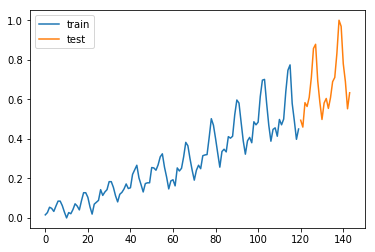

In [8]:
plt.plot(train)
plt.plot(range(120,144),test)
plt.legend(['train', 'test'])

In [111]:
def train_fn(net, n_epochs=100, lr=0.001):
    
    loss_fn = nn.MSELoss()
    losses = [] # For plotting
    optimizer = optim.Adam(net.parameters(), lr=lr)

    input_size = net.input_size
    
    train_loss_epochs = []
    try:
        for epoch in range(n_epochs):
            losses = []

            for it in range(50):
                _inputs = sample(input_size+1, train)
                inputs = Variable(torch.from_numpy(_inputs[:-1]).float())
                targets = Variable(torch.from_numpy(_inputs[1:]).float())

                outputs = net(inputs, None)[0]

                loss = loss_fn(outputs, targets)
                optimizer.zero_grad()

                loss.backward()
                optimizer.step()
                losses.append(loss.data[0])
            train_loss_epochs.append(np.mean(losses))
            
            sys.stdout.write('\rEpoch {0}...  MSE: {1:.5f}'.format(
                        epoch, train_loss_epochs[-1]))


    except KeyboardInterrupt:
        pass
    
    
    #plt.figure(figsize=(12, 5))
    plt.figure(figsize=(8,4))

    plt.plot(train_loss_epochs[1:], label='Train')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

## Своя LSTM

## LSTM PyTorch

In [180]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        
        self.inp = nn.Linear(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, 1)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_, hidden=None):

        input_ = self.inp(input_.view(1, -1)).unsqueeze(1)
        output, hidden = self.rnn(input_, hidden)
        output = self.out(output.squeeze(1))
        return output[0], hidden

In [182]:
model = MyRNN(80, 100, 80)

Epoch 199...  MSE: 0.00003

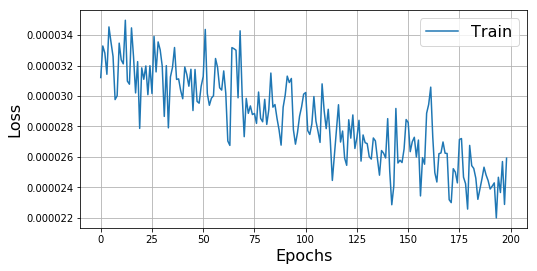

In [197]:
train_fn(model, lr=0.0001, n_epochs=200)

MSE = 0.0505775408764


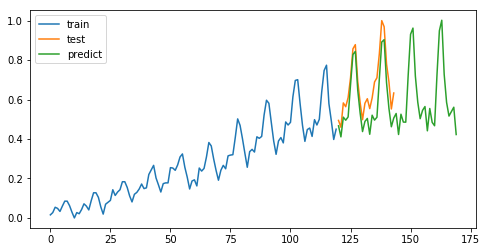

In [198]:
predict_row(model, 50)

## LSTM PyTorch

In [7]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        
        self.inp = nn.Linear(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, 1)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_, hidden=None):

        input_ = self.inp(input_.view(1, -1)).unsqueeze(1)
        output, hidden = self.rnn(input_, hidden)
        output = self.out(output.squeeze(1))
        return output[0], hidden

In [114]:
def predict_row(net, to_pred):
    
    pred = []
    input_size = net.input_size
    _inputs = train[-net.input_size:]
    inputs = Variable(torch.from_numpy(_inputs).float())


    output, hidden = net(inputs, None)
    output[:-1] = inputs[1:]

    pred.append(output[-1].data[0])

    for i in range(to_pred-1):
        out_prev = output
        output, hidden = net(out_prev, None)
        output[:-1] = out_prev[1:]
        pred.append(output[-1].data[0])

    L = np.min([len(test), len(pred)])    
    
    mse = ((test[:L] - pred[:L])**2).mean()
    print ('MSE =', mse)
    
    plt.figure(figsize=(8,4))

    plt.plot(train)
    plt.plot(range(len(train), len(train)+len(test)), test)
    plt.plot(range(len(train), len(train)+len(pred)), pred)
    plt.legend(['train', 'test', 'predict'])
    
    

### len(input) = 80

In [115]:
model80 = MyRNN(80, 100, 80)

Epoch 199...  MSE: 0.00000

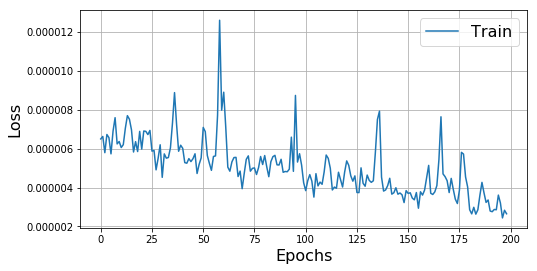

In [161]:
train_fn(model80, lr=0.0001, n_epochs=200)

MSE = 0.0597456356711


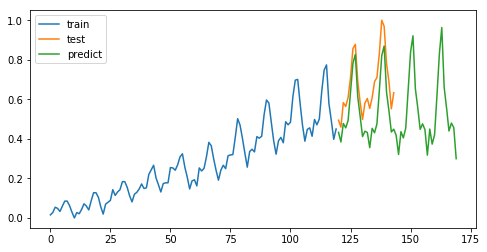

In [162]:
predict_row(model80, 50)

### len(input) = 40

In [163]:
model40 = MyRNN(40, 100, 40)

Epoch 299...  MSE: 0.00000

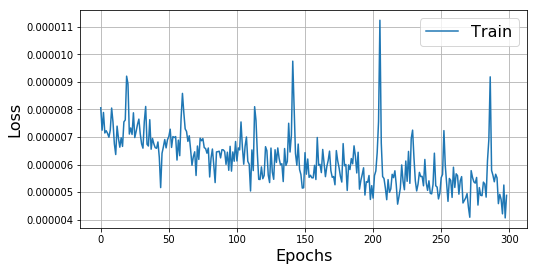

In [172]:
train_fn(model40, lr=0.0001, n_epochs=300)

MSE = 0.125310989711


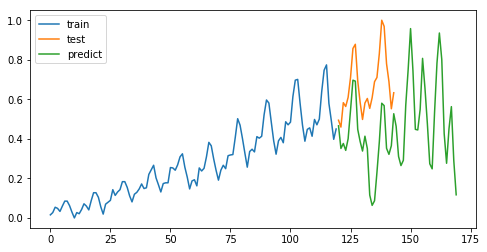

In [173]:
plt.figure(figsize=(8,4))
predict_row(model40, 50)

### len(input) = 20

In [140]:
model20 = MyRNN(20, 100, 20)

Epoch 199...  MSE: 0.00002

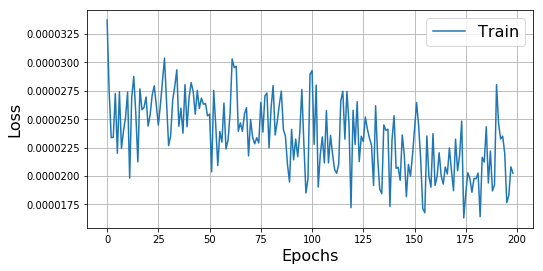

In [144]:
train_fn(model20, lr=0.0001, n_epochs=200)

MSE = 0.0694305077444


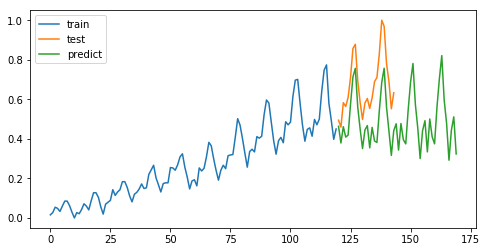

In [175]:
plt.figure(figsize=(8,4))
predict_row(model20, 50)

### len(input) = 10

In [147]:
model10 = MyRNN(10, 100, 10)

Epoch 199...  MSE: 0.00003

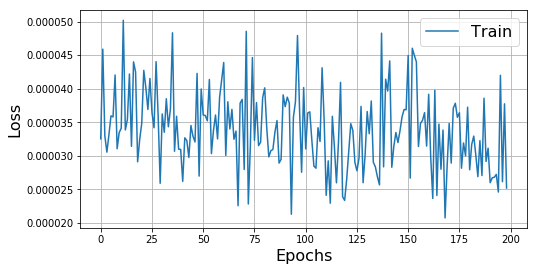

In [176]:
train_fn(model10, lr=0.0001, n_epochs=200)

MSE = 0.0446894771387


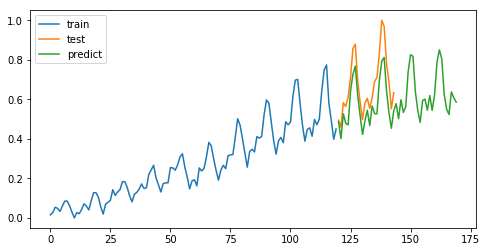

In [177]:
plt.figure(figsize=(8,4))
predict_row(model10, 50)

### len(input) = 5

In [152]:
model5 = MyRNN(5, 100, 5)

Epoch 199...  MSE: 0.00026

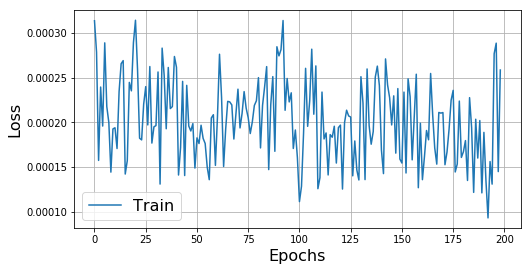

In [156]:
train_fn(model5, lr=0.0001, n_epochs=200)

MSE = 0.0395735258192


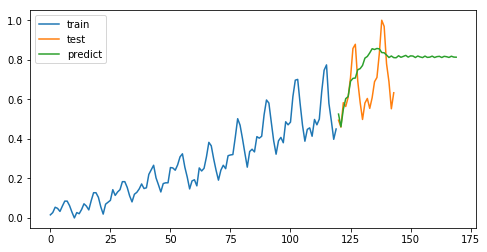

In [178]:
plt.figure(figsize=(8,4))
predict_row(model5, 50)